In [1]:
!pip install -q langchain langgraph transformers accelerate

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to("cuda")

/home/jungi.byun/AMA/solution/jupyter_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-09 19:04:55.843707: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 19:04:55.873629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752055495.908736 3951711 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752055495.919827 3951711 cuda_bl

In [3]:
from typing import TypedDict, Optional, Dict, Any, Annotated, List
from langgraph.graph import StateGraph, END

class GeometryState(TypedDict):
    user_request: str
    math_concept: str = ""
    parameters: Optional[Dict[str, Any]]
    generated_code: str = ""
    comments: str = ""
    formulas: Optional[Dict[str, str]]

In [4]:
import json

def extract_shape_node(state: GeometryState) -> GeometryState:
    messages = [
        {
            "role": "system",
            "content": """
                사용자가 제공하는 수학과 관련된 문장{state["user_request"]}에서 어떠한 개념을 설명하면 사용자의 이해를 도울 수 있을지, JSON 형식으로 출력하세요.
                아래 JSON의 schema에 맞게 하나만 출력하세요. 다른 설명은 절대 추가하지 마세요.
                쉼표, 따옴표, 중괄호 등 문법을 엄격히 지키세요. 문제가 있어도 반드시 완전한 JSON으로만 출력하세요.
                반드시 문장{state["user_request"]}에서 직접 유도할 수 있는 가장 정확한 개념만 선택하세요.
                예를 들어 각, 예각, 예각삼각형을 잘 구분해야 합니다.
                출력 형식 예시 (값은 사용자가 제공하는 수학과 관련된 문장{state["user_request"]}에서 나온 개념과 인자를 사용해야 합니다):
                {
                    "math_concept": "원"
                    "parameters": {
                        "radius": 1
                    }
                }
                사용자의 이해를 도울 수 있는 수학 개념과 이에 연관된 인자는 다음과 같습니다. 각 개념에 연관되지않는 인자는 JSON에 포함하지마세요.
                (사용자가 제공하는 수학과 관련된 문장에서 찾은 개념의 영단어와 문장을 영어로 번역한 것과 비교하여 찾고, 반드시 한국어로 된 개념을 사용하세요.)
                    - 선분(Line Segment) 또는 반직선(Half Line) 또는 곧은선, 직선(Line, Straight Line)
                        - 인자 없음
                    - 굽은선, 곡선(Curve)
                        - 인자 없음
                    - 각(Angle) 또는 각도(Angle)
                        - size(예: 60° = 60): 각의 크기(int), 90은 직각을 사용하세요
                    - 직각(Right Angle) 또는 수직(Perpendicular), 수선(Perpendicular Line)
                    - 직각삼각형(Right Triangle)
                        - base: 직각삼각형의 밑변의 길이(int)
                        - height: 직각삼각형의 높이(int)
                    - 사각형(Quadrangle) 또는 직사각형(Rectangle)
                        - width: 직사각형의 가로(밑변)의 길이(int)
                        - height: 직사각형의 세로(높이)의 길이(int)
                    - 정사각형(Square)
                        - length: 정사각형의 한변의 길이(int)
                    - 원(Circle)
                        - radius: 원의 반지름의 길이(int)
                    - 예각(Acute angle)
                        - size(예: 30° = 30): 예각의 크기(int)
                    - 둔각(Obtuse angle)
                        - size(예: 120° = 120): 둔각의 크기(int)
                    - 정삼각형(Equilateral)
                        - length: 정삼각형의 한변(등변)의 길이(int)
                    - 이등변삼각형(Isosceles)
                        - length: 이등변삼각형의 등변의 길이(int)
                        - angle: 이등변삼각형의 등변 사잇각의 크기(int)
                    - 삼각형(Triangle) 또는 예각삼각형(Acute Triangle)
                        - 인자 없음
                    - 둔각삼각형(Obtuse Triangle)
                        - 인자 없음
             """
        },
        {
            "role": "user",
            "content": state["user_request"]
        }
    ]
    
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    )

    output = model.generate(
        input_ids.to("cuda"),
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=256,
        do_sample=True,
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    
    # 마크다운 제거 로직
    decoded = decoded[decoded.find("```json") + len("```json"):decoded.rfind("```")]
    parsed = json.loads(decoded)

    state["math_concept"] = parsed["math_concept"]
    if parsed["parameters"] is not None:
        state["parameters"] = parsed["parameters"]
        
    return state

In [5]:
def gen_lines_prototype(svg_frame=500, stroke="black", stroke_width=2):
    """
    곧은선(선분, 반직선, 직선)을 그리는 코드 문자열을 생성합니다.

    Parameters:
        svg_frame (int): SVG 전체 너비 및 높이
        stroke (str): 선 색상
        stroke_width (int): 선 두께

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    x0, y0 = svg_frame // 4, svg_frame // 4
    x1, y1 = svg_frame // 4, svg_frame // 2
    x2, y2 = svg_frame // 4, (svg_frame * 3) // 4

    distance = svg_frame // 2

    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 20}" font-size="{svg_frame // 20}" text-anchor="middle">곧은선</text>
    <text x="{svg_frame // 2}" y="{(svg_frame * 3) // 20}" font-size="{svg_frame // 20}" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="{x0}" cy="{y0}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x0 + distance}" cy="{y0}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 반직선 -->
    <text x="{svg_frame // 2}" y="{(svg_frame * 7) // 20}" font-size="{svg_frame // 20}" text-anchor="middle">반직선</text>
    <circle cx="{x1}" cy="{y1}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x1 + distance}" cy="{y1}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{x1}" y1="{y1}" x2="{svg_frame}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 직선 -->
    <text x="{svg_frame // 2}" y="{(svg_frame * 3) // 5}" font-size="{svg_frame // 20}" text-anchor="middle">직선</text>
    <circle cx="{x2}" cy="{y2}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x2 + distance}" cy="{y2}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="0" y1="{y2}" x2="{svg_frame}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''
    
    return svg_content

In [6]:
import math

def gen_curves_prototype(svg_frame=500, stroke="black", stroke_width=2):
    """
    굽은선(곡선)을 그리는 코드 문자열을 생성합니다.

    Parameters:
        svg_frame (int): SVG 전체 너비 및 높이
        stroke (str): 선 색상
        stroke_width (int): 선 두께

    Returns:
        svg_content (str): SVG 코드 문자열
    """
    
    svg_content = f'''
    <svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M {svg_frame // 5},{(svg_frame * 4) // 5}
    C {svg_frame // 5},{svg_frame // 5} {(svg_frame * 4) // 5},{svg_frame // 5} {(svg_frame * 4) // 5},{svg_frame // 2}
    C {(svg_frame * 4) // 5},{(svg_frame * 4) // 5} {svg_frame // 5},{(svg_frame * 4) // 5} {svg_frame // 5},{svg_frame // 5}"
    stroke="{stroke}" fill="none" stroke-width="{stroke_width}"/>
    </svg>
    '''
    return svg_content

In [7]:
def gen_circle_prototype(variants=None, svg_frame=500, stroke="black", stroke_width=2, fill="none"):
    """
    원을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        variants (dict): 원의 인자
            radius (int): 원의 반지름
        svg_frame (int): SVG 전체 너비 및 높이
        stroke (str): 선 색상
        stroke_width (int): 선 두께
        fill (str): 내부 색상

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    cx = svg_frame // 2
    cy = cx
    
    if (variants is None) or ("radius" not in variants.keys()) or (variants["radius"] is None) or (variants["radius"] <= 0):
        r = svg_frame // 3
    else:
        r = min(variants["radius"] * 50, svg_frame // 3)
    
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">원</text>
    <circle cx="{cx}" cy="{cy}" r="{r}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx}" cy="{cy}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{cx}" y1="{cy}" x2="{cx + r}" y2="{cy}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 보조선 -->
    <path d="M {cx}, {cy} Q {cx + (r // 2)}, {cy - (r // 8)} {cx + r}, {cy}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{cx + (r // 2)}" y="{cy - (r // 8)}" font-size="{svg_frame // 40}" text-anchor="middle">반지름</text>
    </svg>
    '''

    return svg_content

In [8]:
def gen_rectangle_prototype(variants=None, is_square=False, svg_frame=500, stroke="black", stroke_width=2, fill="none"):
    """
    직사각형을 그리는 코드 문자열을 생성합니다.

    Parameters:
        variants (dict): 사각형 인자
            width (int): 직사각형 너비
            height (int): 직사각형 높이
            length (int): 정사각형 한 변의 길이
        is_square (bool): 정사각형 여부
        svg_frame (int): SVG 전체 너비 및 높이
        stroke (str): 테두리 색상
        stroke_width (int): 테두리 두께
        fill (str): 내부 색상

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    x = svg_frame // 5
    y = svg_frame // 5
    if is_square:
        r_width = (svg_frame * 3) // 5 if (variants is None) or ("length" not in variants.keys()) or (variants["length"] is None) or (variants["length"] <= 0) else min((svg_frame * 3) // 5, variants["length"] * 100)
        r_height = r_width
        svg_height = svg_frame
        name = "정사각형"
    else:
        r_width = (svg_frame * 3) // 5  if (variants is None) or ("width" not in variants.keys()) or (variants["width"] is None) or (variants["width"] <= 0) else min((svg_frame * 3) // 5, variants["width"] * 50)
        r_height = r_width // 2 if (variants is None) or ("height" not in variants.keys()) or (variants["height"] is None) or (variants["height"] <= 0) else min(r_width // 2, variants["height"] * 50)
        svg_height = min(500, ((y + r_height) * 5) // 4)
        name = "직사각형"

    # 사각형이 가로로 중앙에 위치하도록
    x = (svg_frame - r_width) // 2

    # 직사각형, 정사각형에 따른 용어 변경
    if is_square:
        base_term = "한변"
        height_term = "한변"
    else:
        base_term = "밑변"
        height_term = "높이"

    epsilon = min(r_width, r_height) // 5
    
    # svg_width = x + width + x, svg_height = y + height + y
    svg_content = f'''<svg width="{svg_frame}" height="{svg_height}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{name}</text>
    <rect x="{x}" y="{y}" width="{r_width}" height="{r_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <!-- 보조선들 -->
    <path d="M {x}, {y + r_height} Q {x + (r_width // 2)}, {y + r_height - epsilon} {x + r_width}, {y + r_height}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{x + (r_width // 2)}" y="{y + r_height - epsilon}" font-size="{svg_frame // 40}" text-anchor="middle">{base_term}</text>
    <path d="M {x + r_width}, {y} Q {x + r_width - epsilon}, {y + (r_height // 2)} {x + r_width}, {y + r_height}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{x + r_width - epsilon}" y="{y + (r_height // 2)}" font-size="{svg_frame // 40}" text-anchor="middle">{height_term}</text>
    </svg>'''
    return svg_content

In [9]:
import math

def gen_angle_prototype(variants=None, svg_frame=500, stroke="black", stroke_width=2):
    """
    기준선과 기울어진 선 + 각도를 나타내는 호를 그리는 코드 문자열을 생성합니다.

    Parameters:
        variants (dict): 각도 인자
            size (int): 각의 크기
        svg_frame (int): SVG 전체 너비 및 높이
        stroke (str): 테두리 색상
        stroke_width (int): 테두리 두께

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    angle_deg = 60 if (variants is None) or ("size" not in variants.keys()) or (variants["size"] is None) else variants["size"]
    if 180 < angle_deg:
        angle_deg = angle_deg % 180
    
    # 기준점
    x0, y0 = svg_frame // 4 if angle_deg < 90 else svg_frame // 2, (svg_frame * 2) // 3

    # 기준선 끝점 (수평)
    line_length = svg_frame // 2
    x1 = x0 + line_length
    y1 = y0

    # 기울어진 선 끝점
    rad = math.radians(angle_deg)
    x2 = x0 + line_length * math.cos(-rad)
    y2 = y0 + line_length * math.sin(-rad)

    # 호의 시작점 (반지름만큼 떨어진 점)
    arc_radius = svg_frame // 10
    arc_start_x = x0 + arc_radius * math.cos(-rad)
    arc_start_y = y0 + arc_radius * math.sin(-rad)

    # 호의 끝점 (반지름과 각도로 계산)
    arc_end_x = x0 + arc_radius
    arc_end_y = y0

    # SVG 내용
    svg_content = f'''<svg width="{svg_frame}" height="{(svg_frame * 3) // 4}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="{x0}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 기울어진 선 -->
    <line x1="{x0}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 각도 호 -->
    <path d="M {arc_start_x},{arc_start_y} A {arc_radius},{arc_radius} 0 0,1 {arc_end_x},{arc_end_y}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
    <!-- 보조선 -->
    <text x="{x0 + arc_radius * 1.25 * math.cos(-rad / 2)}" y="{y0 + arc_radius * 1.25 * math.sin(-rad / 2)}" font-size="{svg_frame // 40}" text-anchor="middle">{angle_deg}°</text>
    </svg>
    '''

    return svg_content

In [10]:
def gen_right_angle_prototype(concept, svg_frame=500, stroke="black", stroke_width=2):
    """
    직각과 직각을 나타내는 보조선을 그리는 코드 문자열을 생성합니다.

    Parameters:
        svg_frame (int): SVG 전체 너비 및 높이
        stroke (str): 테두리 색상
        stroke_width (int): 테두리 두께

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    concept_e2k = {"Right Angle": "직각", "Perpendicular": "수직", "Perpendicular Line": "수선"}
    concept = concept_e2k[concept] if concept in concept_e2k.keys() else concept
    
    # 기준점
    x0, y0 = svg_frame // 4, (svg_frame * 4) // 5

    # 기준선 끝점 (수평)
    line_length = (svg_frame * 3) // 5
    x1 = x0 + line_length
    y1 = y0

    # 수직 선 끝점
    x2 = x0 + line_length // 3
    y2 = y0 - line_length

    # 직각 보조선
    epsilon = svg_frame // 10

    h1 = x2 + epsilon
    h2 = y0 - epsilon

    # SVG 내용
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
    <!-- 기준선 -->
    <line x1="{x0}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 기울어진 선 -->
    <line x1="{x2}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 직각 보조선 -->
    <line x1="{h1}" y1="{y0}" x2="{h1}" y2="{h2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{x2}" y1="{h2}" x2="{h1}" y2="{h2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''
    
    return svg_content

In [11]:
def gen_right_triangle_prototype(variants=None, svg_frame=500, stroke="black", stroke_width=2):
    """
    직각삼각형을 그리는 코드 문자열을 생성합니다.

    Parameters:
        variants (dict): 직각삼각형의 인자
            base (int): 직각삼각형의 밑변
            height (int): 직각삼각형의 높이
        svg_frame (int): SVG 전체 너비 및 높이
        stroke (str): 테두리 색상
        stroke_width (int): 테두리 두께

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # 기준점
    rt_base = (svg_frame * 2) // 3 if (variants is None) or ("base" not in variants.keys()) or (variants["base"] is None) or (variants["base"] <= 0) else min(variants["base"] * 75, (svg_frame * 2) // 3)
    rt_height = svg_frame // 2 if (variants is None) or ("height" not in variants.keys()) or (variants["height"] is None) or (variants["height"] <= 0) else min(variants["height"] * 75, svg_frame // 2)
    x0, y0 = svg_frame // 6, (svg_frame * 5) // 6
    x1, y1 = min(x0 + rt_base, (svg_frame * 5) // 6), y0
    x2, y2 = x1, max(y1 - rt_height, svg_frame // 3)

    epsilon = min(rt_base, rt_height) // 10

    h1 = x1 - epsilon
    h2 = y1 - epsilon
    
    # SVG 내용
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="{x0}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{x1}" y1="{y1}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{x0}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 직각 보조선 -->
    <line x1="{h1}" y1="{y1}" x2="{h1}" y2="{h2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{h1}" y1="{h2}" x2="{x1}" y2="{h2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 보조선들 -->
    <path d="M {x0}, {y0} Q {(x0 + x1) // 2}, {((y0 + y1) // 2) - epsilon} {x1}, {y1}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{(x0 + x1) // 2}" y="{((y0 + y1) // 2) - epsilon}" font-size="{svg_frame // 40}" text-anchor="middle">밑변</text>
    <path d="M {x1}, {y1} Q {((x1 + x2) // 2) - epsilon}, {(y1 + y2) // 2} {x2}, {y2}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{((x1 + x2) // 2) - 1.2 * epsilon}" y="{(y1 + y2) // 2}" font-size="{svg_frame // 40}" text-anchor="middle">높이</text>
    <path d="M {x0}, {y0} Q {((x0 + x2) // 2) - epsilon}, {(y0 + y2) // 2 - epsilon} {x2}, {y2}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{((x0 + x2) // 2) - 1.2 * epsilon}" y="{(y0 + y2) // 2 - epsilon}" font-size="{svg_frame // 40}" text-anchor="middle">빗변</text>
    </svg>
    '''
    return svg_content

In [12]:
import math

def gen_isosceles_prototype(variants=None, is_equilateral=False, svg_frame=500, stroke="black", stroke_width=2):
    """
    이등변삼각형 및 정삼각형을 그리는 코드 문자열을 생성합니다.

    Parameters:
        variants (dict): 이등변삼각형/정삼각형의 인자
            length (int): 이등변삼각형/정삼각형의 등변의 길이
            angle (int): 등변 사잇각
        is_equilateral (bool): 정삼각형 여부
        svg_frame (int): SVG 전체 너비 및 높이
        stroke (str): 테두리 색상
        stroke_width (int): 테두리 두께

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    if is_equilateral:
        # 정삼각형
        rad = math.pi / 3
        lateral = svg_frame // 2 if (variants is None) or ("length" not in variants.keys()) or (variants["length"] is None) or (variants["length"] <= 0) else min(variants["length"] * 75, svg_frame // 2)
        x0, y0 = svg_frame // 2, svg_frame // 4
        x1, y1 = x0 + lateral * math.cos(rad), y0 + lateral * math.sin(rad)
        x2, y2 = x0 + lateral * math.cos(2 * rad), y0 + lateral * math.sin(2 * rad)

        epsilon = lateral // 10
        same_tick = lateral // 30

        # SVG 내용
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="{x0},{y0} {x1},{y1} {x2},{y2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 보조선들 -->
        <path d="M {x0}, {y0} Q {(x0 + x1) / 2 + epsilon}, {((y0 + y1) / 2) - epsilon} {x1}, {y1}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
        <text x="{(x0 + x1) / 2 + 1.5 * epsilon}" y="{((y0 + y1) / 2) - epsilon}" font-size="{svg_frame // 40}" text-anchor="middle">한변</text>
        <line x1="{(x0 + x1) / 2 - same_tick * math.cos(rad + math.pi / 2)}" y1="{(y0 + y1) / 2 - same_tick * math.sin(rad + math.pi / 2)}" x2="{(x0 + x1)/ 2 + same_tick * math.cos(rad + math.pi / 2)}" y2="{(y0 + y1) / 2 + same_tick * math.sin(rad + math.pi / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(x1 + x2) / 2 - same_tick * math.cos(math.pi / 2)}" y1="{(y1 + y2) / 2 - same_tick * math.sin(math.pi / 2)}" x2="{(x1 + x2) / 2 + same_tick * math.cos(math.pi / 2)}" y2="{(y1 + y2) / 2 + same_tick * math.sin(math.pi / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(x0 + x2) / 2 - same_tick * math.cos(2 * rad + math.pi / 2)}" y1="{(y0 + y2) / 2 - same_tick * math.sin(2 * rad + math.pi / 2)}" x2="{(x0 + x2) / 2 + same_tick * math.cos(2 * rad + math.pi / 2)}" y2="{(y0 + y2) / 2 + same_tick * math.sin(2 * rad + math.pi / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        </svg>
        '''
    else:
        # 이등변삼각형
        rad = math.pi / 6 if (variants is None) or ("angle" not in variants.keys()) or (variants["angle"] is None) or (variants["angle"] <= 0) else math.radians(min(variants["angle"], 178))
        lateral = svg_frame // 2 if (variants is None) or ("length" not in variants.keys()) or (variants["length"] is None) or (variants["length"] <= 0) else min(variants["length"] * 75, svg_frame // 2)
        x0, y0 = svg_frame // 2, svg_frame // 4
        x1, y1 = x0 + lateral * math.cos((math.pi - rad) / 2), y0 + lateral * math.sin((math.pi - rad) / 2)
        x2, y2 = x0 + lateral * math.cos((math.pi + rad) / 2), y0 + lateral * math.sin((math.pi + rad) / 2)

        epsilon = lateral // 10
        same_tick = lateral // 30

        # SVG 내용
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="{x0},{y0} {x1},{y1} {x2},{y2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 보조선들 -->
        <path d="M {x0}, {y0} Q {(x0 + x1) // 2 + epsilon}, {((y0 + y1) // 2) - epsilon} {x1}, {y1}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
        <text x="{(x0 + x1) // 2 + epsilon}" y="{((y0 + y1) // 2) - epsilon}" font-size="{svg_frame // 40}" text-anchor="middle">등변</text>
        <line x1="{(x0 + x1) / 2 - same_tick * math.cos((math.pi - rad) / 2 + math.pi / 2)}" y1="{(y0 + y1) / 2 - same_tick * math.sin((math.pi - rad) / 2 + math.pi / 2)}" x2="{(x0 + x1)/ 2 + same_tick * math.cos((math.pi - rad) / 2 + math.pi / 2)}" y2="{(y0 + y1) / 2 + same_tick * math.sin((math.pi - rad) / 2 + math.pi / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(x0 + x2) / 2 - same_tick * math.cos((math.pi + rad) / 2 + math.pi / 2)}" y1="{(y0 + y2) / 2 - same_tick * math.sin((math.pi + rad) / 2 + math.pi / 2)}" x2="{(x0 + x2)/ 2 + same_tick * math.cos((math.pi + rad) / 2 + math.pi / 2)}" y2="{(y0 + y2) / 2 + same_tick * math.sin((math.pi + rad) / 2 + math.pi / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        </svg>
        '''
        
    return svg_content

In [13]:
import math

def gen_triangles_by_angles_prototype(concept, svg_frame=500, stroke="black", stroke_width=2):
    """
    예각 및 둔각 삼각형을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 각에 따른 삼각형 종류(예각삼각형(Acute Triangle), 둔각삼각형(Obtuse Triangle))
        svg_frame (int): SVG 전체 너비 및 높이
        stroke (str): 테두리 색상
        stroke_width (int): 테두리 두께

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    if concept == "예각삼각형" or concept == "Acute Triangle":
        # 예각 삼각형
        # 예각 삼각형의 세 꼭짓점 좌표 (모두 각이 90도 미만)
        x0, y0 = svg_frame // 2, svg_frame // 4
        x1, y1 = svg_frame // 3, (svg_frame * 4) // 5
        x2, y2 = (svg_frame * 4) // 5, y1

        # SVG 문자열 생성
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">예각삼각형</text>
        <polygon points="{x0},{y0} {x1},{y1} {x2},{y2}" stroke="black" stroke-width="2" fill="none" />
        </svg>
        '''
    else:
        # 둔각삼각형
        x0, y0 = (svg_frame * 3) // 4, svg_frame // 4
        x1, y1 = (svg_frame * 3) // 5, (svg_frame * 4) // 5
        x2, y2 = svg_frame // 4, y1

        # SVG 문자열 생성
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">둔각삼각형</text>
        <polygon points="{x0},{y0} {x1},{y1} {x2},{y2}" stroke="black" stroke-width="2" fill="none" />
        </svg>
        '''
        
    return svg_content

In [14]:
import random

supported_triangles = ["직각삼각형", "정삼각형", "이등변삼각형", "예각삼각형", "둔각삼각형"]

def generate_code_node(state: GeometryState) -> GeometryState:
    concept = state["math_concept"]
    parameters = state["parameters"] if "parameters" in state.keys() else None

    
    if concept == "삼각형" or concept == "Triangle":
        concept = random.choice(supported_triangles)

    if concept == "원" or concept == "원주" or concept == "원주율" or concept == "Circle":
        code = gen_circle_prototype(parameters)
    elif concept == "선분" or concept == "반직선" or concept == "직선" or concept == "곧은선" or concept == "Line":
        code = gen_lines_prototype()
    elif concept == "곡선" or concept == "굽은선" or concept == "Curve":
        code = gen_curves_prototype()
    elif concept == "각" or concept == "각도" or concept == "Angle":
        code = gen_angle_prototype(parameters)
    elif concept == "직각" or concept == "Right Angle" or concept == "수직" or concept == "Perpendicular" or concept == "수선" or concept == "Perpendicular Line":
        code = gen_right_angle_prototype(concept)
    elif concept == "직각삼각형" or concept == "Right Triangle":
        code = gen_right_triangle_prototype(parameters)
    elif concept == "직사각형" or concept == "Rectangle" :
        code = gen_rectangle_prototype(parameters)
    elif concept == "정사각형" or concept == "Square":
        code = gen_rectangle_prototype(parameters, True)
    elif concept == "예각" or concept == "Acute angle" or concept == "둔각" or concept == "Obtuse angle":
        code = gen_angle_prototype(parameters)
    elif concept == "정삼각형" or concept == "Equilateral":
        code = gen_isosceles_prototype(parameters, True)
    elif concept == "이등변삼각형" or concept == "Isosceles":
        code = gen_isosceles_prototype(parameters)
    elif concept == "예각삼각형" or concept == "Acute Triangle" or concept == "둔각삼각형" or concept == "Obtuse Triangle":
        code = gen_triangles_by_angles_prototype(concept)
    else:
        code = f'''<svg width="{500}" height="{500}" xmlns="http://www.w3.org/2000/svg">
        <text x="{250}" y="{50}" font-size="{12}" text-anchor="middle"># {concept}을(를) 그리는 코드는 아직 구현되지 않았습니다.</text>
        </svg>
        '''

    # return {**state, "generated_code": code}
    return {"generated_code": code}

In [15]:
def generate_comments_node(state: GeometryState) -> GeometryState:
    messages = [
        {
            "role": "system",
            "content": '''
                당신은 초등학생들이 수학 문제를 풀 때 힌트를 제공하는 초등학교 선생님입니다.
                수학 개념{state["user_request"]}에 대한 설명을 다음 내용을 포함하여 간결하게 한국어로만 제공해주세요.
                    - 정의
                    - 기본 성질(공식은 제외하세요)
                원주율을 반드시 π(\pi)가 아닌 3.14로하여 제공해주세요.
             '''
        },
        {
            "role": "user",
            "content": state["user_request"]
        }
    ]
    
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    )

    output = model.generate(
        input_ids.to("cuda"),
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False,
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # 답변 추출 로직
    decoded = decoded[decoded.find("[|assistant|]") + len("[|assistant|]"):]

    # state["comments"] = decoded

    return {"comments": decoded}

In [16]:
def generate_formulas_node(state: GeometryState) -> GeometryState:
    supported_shape = {"직각삼각형": "Right Triangle", "직사각형": "Rectangle", "정사각형": "Square", "원": "Circle"}

    math_concept = state["math_concept"]
    if math_concept not in supported_shape.keys() and math_concept not in supported_shape.values():
        return state
        
    messages = [
        {
            "role": "system",
            "content": '''
                당신은 초등학생들이 수학 문제를 풀 때 힌트를 제공하는 초등학교 선생님입니다.
                초등학생의 이해를 돕기위해, 수학 개념{state["math_concept"]}에 대한 둘레와 넓이 공식을 JSON 형식으로 출력하세요.
                아래 JSON의 schema에 맞게 하나만 출력하세요. 다른 설명은 절대 추가하지 마세요.
                쉼표, 따옴표, 중괄호 등 문법을 엄격히 지키세요. 문제가 있어도 반드시 완전한 JSON으로만 출력하세요.
                출력 형식 예시 (값은 {state["math_concept"]}에 대한 둘레와 넓이 공식을 사용하세요.):
                {
                    "formulas": {
                        "perimeter": "2 \\times 3.14(원주율) \\times \mathrm{반지름}",
                        "area": "3.14(원주율) \\times \mathrm{반지름} \\times \mathrm{반지름}",
                    }
                }
                공식을 제공할 수 있는 개념은 다음과 같습니다. (사용자가 제공하는 수학과 관련된 문장에서 찾은 개념의 영단어와 문장을 영어로 번역한 것과 비교하여 찾아보세요)
                    - 직각삼각형(Right Triangle)
                        - 둘레: 밑변 + 높이 + 빗변
                        - 넓이: 밑변 × 높이 ÷ 2
                    - 직사각형(Rectangle)
                        - 둘레: 2 × (밑변 + 높이)
                        - 넓이: 밑변 × 높이                    
                    - 정사각형(Square)
                        - 둘레: 4 × 한 변의 길이
                        - 넓이: 한 변의 길이 × 한 변의 길이
                    - 원(Circle) 또는 원주
                        - 둘레(원주): 2 × 3.14 × 반지름
                        - 넓이: 3.14 × 반지름 × 반지름
                원주율을 π(\pi)가 아닌 3.14로하여 제공해주세요.
             '''
        },
        {
            "role": "user",
            "content": state["math_concept"]
        }
    ]
    
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    )

    output = model.generate(
        input_ids.to("cuda"),
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False,
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # 마크다운 제거 로직
    decoded = decoded[decoded.find("```json") + len("```json"):decoded.rfind("```")]
    decoded = decoded.replace('\\', '\\\\')
    parsed = json.loads(decoded)
    
    # state["formulas"] = parsed["formulas"]

    return {"formulas": parsed["formulas"]}

In [17]:
def merge_hints(state: GeometryState) -> GeometryState:
    return state

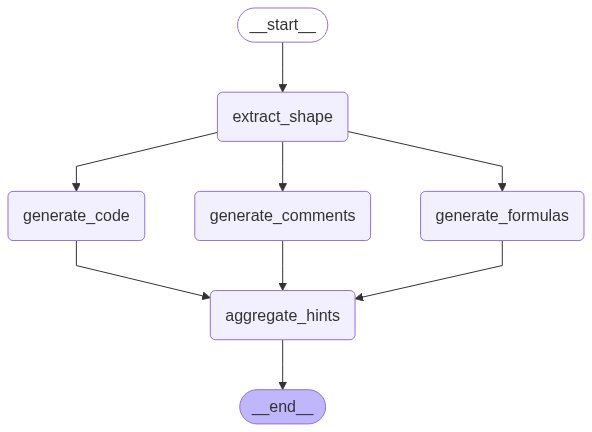

In [18]:
# LangGraph StateGraph 생성
geometry_agent = StateGraph(GeometryState)

# 노드 등록
geometry_agent.add_node("extract_shape", extract_shape_node)
geometry_agent.add_node("generate_code", generate_code_node)
geometry_agent.add_node("generate_comments", generate_comments_node)
geometry_agent.add_node("generate_formulas", generate_formulas_node)
geometry_agent.add_node("aggregate_hints", merge_hints)

# 엣지 연결
geometry_agent.set_entry_point("extract_shape")
geometry_agent.add_edge("extract_shape", "generate_code")
geometry_agent.add_edge("extract_shape", "generate_comments")
geometry_agent.add_edge("extract_shape", "generate_formulas")
geometry_agent.add_edge("generate_code", "aggregate_hints")
geometry_agent.add_edge("generate_comments", "aggregate_hints")
geometry_agent.add_edge("generate_formulas", "aggregate_hints")
geometry_agent.add_edge("aggregate_hints", END)

# 그래프 완성
app = geometry_agent.compile()
app

In [19]:
from IPython.display import SVG, display

def show_svg(svg_content):
    display(SVG(svg_content))

In [20]:
from IPython.display import Math, display

def show_formulas(formula):
    display(Math(formula))

In [21]:
# inputs = [
#     "곧은선이 뭐야?",
#     "대표적인 굽은선을 그려줘",
#     "중심이 (0,0)이고 반지름이 2인 원을 그려주세요.",
#     "37° 각도를 그려줘",
#     "직각을 표현해줘",
#     "밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘",
#     "가로가 5, 세로가 3인 직사각형의 넓이",
#     "한 변의 길이가 2인 정사각형 하나를 그려줘",
#     "예각의 예시를 그려줘",
#     "둔각을 설명한다",
#     "정삼각형에 대해 이해한다",
#     "이등변삼각형은 정삼각형인가요?",
#     "예각삼각형",
#     "둔각삼각형",
#     """### 요약 내용:
# - **핵심 개념**: 원주의 계산 방법, 특히 지름과 원주율을 이용한 원주 길이의 계산. 주어진 예제에서는 지름이 4cm일 때 원주를 계산하는 방법을 다룸.
# - **학습 목표**: 학생들이 원주의 개념을 이해하고, 주어진 지름과 원주율 값을 이용해 원주를 정확하게 계산할 수 있도록 하는 것.
#     """,
# ]

In [22]:
inputs = [
    "직선 알아보기",
    "각 알아보기",
    "직각 알아보기",
    "직각삼각형 알아보기",
    "직사각형의 성질 알아보기",
    "직사각형의 특징 알아보기",
    "정사각형의 특징 알아보기",
    "원의 반지름과 지름 알아보기",
    "지름의 성질 알아보기",
    "원 그리기",
    "원을 이용하여 여러가지 모양 그리기",
    "각의 크기 비교하기",
    "각도기를 이용하여 각도 재기",
    "각도를 나타내는 단위 알아보기",
    "각도기와 자를 이용하여 각 그리기",
    "예각과 둔각 알아보기",
    "각도를 어림하고 각도기로 재어 확인하기",
    "각도의 합 또는 차의 활용",
    "두 각도의 차 구하기",
    "삼각형에서 나머지 한 각의 크기 구하기",
    "삼각형의 세 각의 크기의 합 구하기",
    "사각형의 나머지 한 각의 크기 구하기",
    "사각형의 네 각의 크기의 합 구하기",
    "삼각형의 변의 길이에 따라 분류하기",
    "이등변삼각형 알아보기",
    "이등변삼각형의 성질 알아보기",
    "각을 이용하여 이등변삼각형 그리기",
    "정삼각형의 성질 알아보기",
    "정삼각형 알아보기",
    "예각삼각형 알아보기",
    "삼각형을 각의 크기에 따라 분류하기",
    "둔각삼각형 알아보기",
    "삼각자와 각도기를 이용한 수선 긋기",
    "수직",
    "삼각자를 사용하여 평행선 긋기",
    "주어진 거리의 평행선 긋기",
    "평행 알아보기",
    "평행선 사이의 거리 알아보기",
    "사다리꼴 알아보기",
    "평행사변형의 성질 알아보기",
    "평행사변형 알아보기",
    "마름모 알아보기",
    "마름모의 성질 알아보기",
    "직사각형과 정사각형의 성질 활용",
    "다각형과 다각형의 이름 알아보기",
    "정다각형과 정다각형의 이름 알아보기",
    "대각선의 성질 알아보기",
    "대각선 알아보기",
    "모양 만들기",
]

input_samples = inputs[:] # 일정 범위만 잘라서 테스트

요청한 문장: 직선 알아보기
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black" 

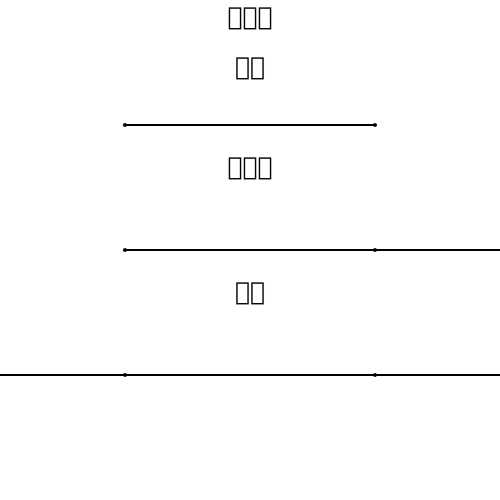

요청한 문장: 각 알아보기
추출된 개념: 각
추출된 인자: {'size': 45}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="301.7766952966369" y2="156.22330470336314" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 160.35533905932738,297.6446609406726 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    <!-- 보조선 -->
    <text x="182.74247078195543" y="309.08228547718187" font-size="12" text-anchor="middle">45°</text>
    </svg>
    

생성된 설명:
 ### 각 알아보기 (Angle)

**정의:**
각 알아보기는 평면 위에서 두 직선이나 곡선이 만나는 지점에서 형성되는 도형의 크기를 말합니다. 각도는 주로 도(°) 단위로 측정되며, 이는 한 원의 중심각이 얼마나 큰지를 나타내기도 합니다.

**기본 성질:**
1. **합의 성질:** 두 각의 크기를 더하면 그 합은 항상 180°가 됩니다. 즉, 서로 마주보는 각들은 직각(90°)을 이루며, 이 두 각을 합치면 완전한 직선이 됩니다.
   
2. **차의 성질:** 두 각의 크기를 빼면 그 차이는 항상 180° 미만입니

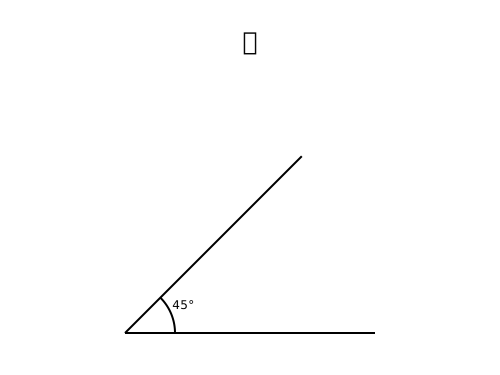

요청한 문장: 직각 알아보기
추출된 개념: 직각
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="425" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="225" y1="400" x2="225" y2="100" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="275" y1="400" x2="275" y2="350" stroke="black" stroke-width="2" />
    <line x1="225" y1="350" x2="275" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### 직각 알아보기

#### 정의
직각은 두 선분이 서로 만나서 **90도**의 각을 이루는 것을 말해요. 쉽게 말해, 직각은 평평한 표면에서 만나는 선들이 만드는 특별한 각도예요.

#### 기본 성질
1. **두 직각이 만나면 평행사변형이 된다**: 만약 두 개의 직각이 서로 맞닿아 있다면, 그 두 선분이 만드는 각을 포함하는 도형은 평행사변형이 될 수 있어요.
2. **직각의 합은 항상 180도**: 한 직선 위에 있는 모든 각들의 합은 항상 180도예요. 따라서 두 개의 직각이 만나면 그 합은 정확히 180도가 됩니다.
3. **직각을 이루는 선분들은 서로 수직**: 직각을 이루는 두 선분은 서로 수직으로 만나요. 즉, 한 선분이 다른 선분과 만나는 각도가 정확히 90도라는 뜻이에요.

이런 성질들을 기억하면 

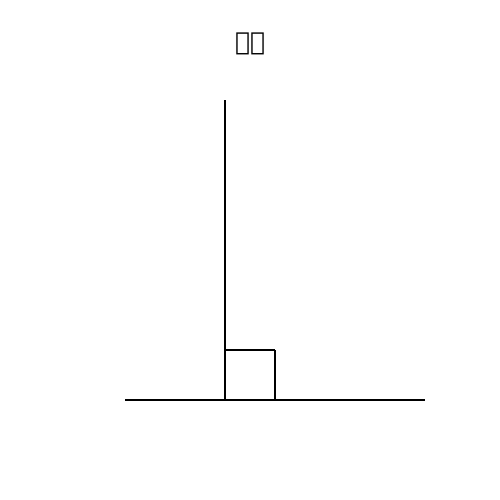

요청한 문장: 직각삼각형 알아보기
추출된 개념: 직각삼각형
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="416" y2="416" stroke="black" stroke-width="2" />
    <line x1="416" y1="416" x2="416" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="416" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="391" y1="416" x2="391" y2="391" stroke="black" stroke-width="2" />
    <line x1="391" y1="391" x2="416" y2="391" stroke="black" stroke-width="2" />
    <!-- 보조선들 -->
    <path d="M 83, 416 Q 249, 391 416, 416" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="249" y="391" font-size="12" text-anchor="middle">밑변</text>
    <path d="M 416, 416 Q 391, 291 416, 166" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="386.0" y="291" font-size="12" te

<IPython.core.display.Math object>

<IPython.core.display.Math object>

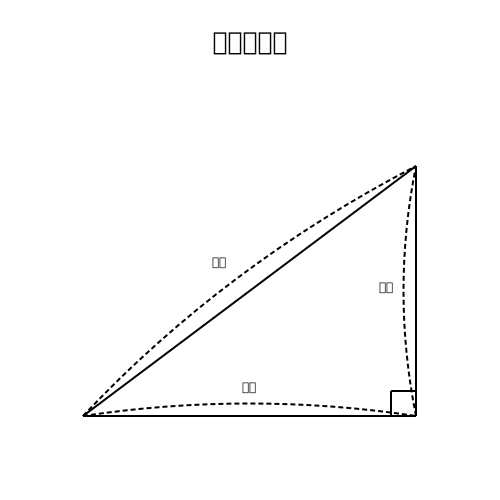

요청한 문장: 직사각형의 성질 알아보기
추출된 개념: 직사각형
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="281" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="125" y="100" width="250" height="125" stroke="black" stroke-width="2" fill="none" />
    <!-- 보조선들 -->
    <path d="M 125, 225 Q 250, 200 375, 225" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="200" font-size="12" text-anchor="middle">밑변</text>
    <path d="M 375, 100 Q 350, 162 375, 225" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="350" y="162" font-size="12" text-anchor="middle">높이</text>
    </svg>

생성된 설명:
 ### 직사각형의 성질

#### 정의
직사각형은 네 개의 변을 가지고 있으며, 이 중 두 쌍의 변이 각각 평행하고 길이가 같은 특별한 사각형입니다. 즉, 모든 내각이 직각(90도)을 이루는 사각형입니다.

#### 기본 성질
1. **대변의 길이 동일**: 직사각형에서는 대변(가로와 세로에 해당하는 변)의 길이가 항상 같습니다. 예를 들어, 가로 길이가 \(a\)이고 세로 길이가 \(b\)라면, \(a = b\)입니다.
   
2. **내각의 합**: 직사각형의 모든 내각은 정확

<IPython.core.display.Math object>

<IPython.core.display.Math object>

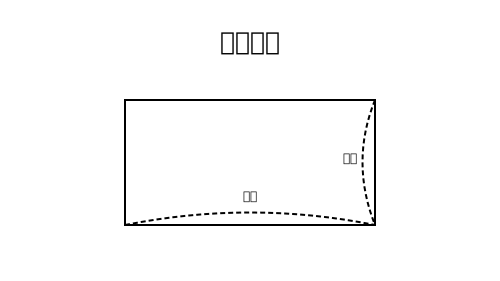

요청한 문장: 직사각형의 특징 알아보기
추출된 개념: 직사각형
추출된 인자: {'width': None, 'height': None}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    <!-- 보조선들 -->
    <path d="M 100, 250 Q 250, 220 400, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="220" font-size="12" text-anchor="middle">밑변</text>
    <path d="M 400, 100 Q 370, 175 400, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="370" y="175" font-size="12" text-anchor="middle">높이</text>
    </svg>

생성된 설명:
 ### 직사각형의 특징

#### 정의
직사각형은 네 개의 변을 가지고 있으며, 이 중 서로 마주보는 두 변은 길이가 같고, 네 각은 모두 직각(90도)인 도형입니다. 즉, 모든 내각이 90도로 평평하고 직선으로 이루어져 있습니다.

#### 기본 성질
1. **대변의 길이 동일**: 직사각형에서 마주보는 두 변의 길이는 항상 같습니다. 예를 들어, 길이가 \( l \)인 한 변과 너비가 \( w \)인 다른 변은 \( l = w \)가 됩니다.
   
2. **대각선의

<IPython.core.display.Math object>

<IPython.core.display.Math object>

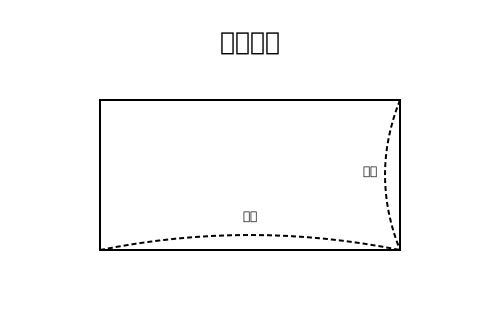

요청한 문장: 정사각형의 특징 알아보기
추출된 개념: 정사각형
추출된 인자: {'length': 5}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    <!-- 보조선들 -->
    <path d="M 100, 400 Q 250, 340 400, 400" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="340" font-size="12" text-anchor="middle">한변</text>
    <path d="M 400, 100 Q 340, 250 400, 400" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="340" y="250" font-size="12" text-anchor="middle">한변</text>
    </svg>

생성된 설명:
 ### 정사각형의 특징

#### 정의
정사각형은 네 개의 변과 네 개의 각이 모두 같은 길이를 가지는 사각형입니다. 모든 내각은 직각(90도)이며, 이로 인해 모든 변의 길이도 동일합니다.

#### 기본 성질
1. **모든 변의 길이 동일**: 정사각형의 네 변은 모두 같은 길이를 가지고 있습니다.
2. **모든 내각 동일**: 정사각형의 네 각은 모두 90도입니다.
3. **대각선의 길이 동일**: 정사각형의 대각선은 서로 길이가 같으며, 이 길이는 변의 길이와 관련된 특별한 공식을 통해 계산할 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

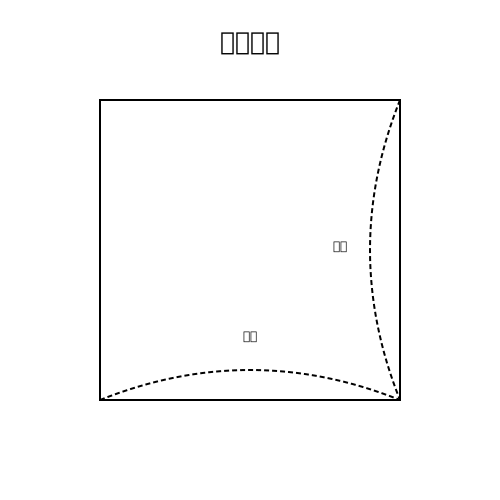

요청한 문장: 원의 반지름과 지름 알아보기
추출된 개념: 원
추출된 인자: {'radius': None, 'diameter': None}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 230 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="230" font-size="12" text-anchor="middle">반지름</text>
    </svg>
    

생성된 설명:
 ### 원의 반지름과 지름 알아보기

#### 정의
- **반지름 (Radius)**: 원의 중심에서 원의 가장자리까지의 거리를 말합니다. 쉽게 말해, 원의 중심을 지나는 직선이 원의 가장자리까지 닿는 길이입니다. 반지름은 항상 원의 크기에 따라 달라집니다.
  
- **지름 (Diameter)**: 원의 가장자리를 가장 멀리 지나는 직선의 길이를 의미합니다. 이 직선은 원의 중심을 지나며, 원의 가장자리 두 점을 연결합니다. 지름은 반지름의 두 배입니다. 즉, 반지름을 \( r \)이라고 할 때 지름은 \( 2r \)로 표

<IPython.core.display.Math object>

<IPython.core.display.Math object>

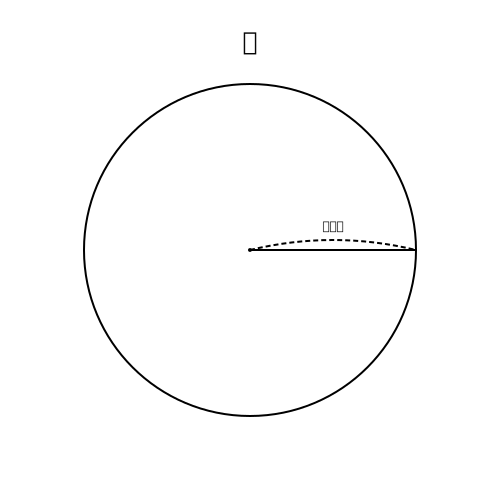

요청한 문장: 지름의 성질 알아보기
추출된 개념: 원
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 230 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="230" font-size="12" text-anchor="middle">반지름</text>
    </svg>
    

생성된 설명:
 ### 지름의 성질

#### 정의
지름은 원의 한 점에서 다른 한 점을 잇는 선분으로, 이 선분이 원의 중심을 지나는 것을 말합니다. 쉽게 말해, 원의 가장 넓은 직선 거리를 지름이라고 부릅니다.

#### 기본 성질
1. **중심을 지나는 선분**: 지름은 항상 원의 중심을 지나갑니다. 이는 원의 대칭성을 보여주는 중요한 특징입니다.
2. **반지름의 두 배**: 원의 지름은 그 원의 반지름의 두 배입니다. 만약 반지름이 \( r \)이라면, 지름은 \( 2r \)이 됩니다.
3. **직경과 둘레의 관계**: 원의 둘레는 지름에 π(\(\pi\))를 곱한 값입니다. 즉, 원의 둘레 \

<IPython.core.display.Math object>

<IPython.core.display.Math object>

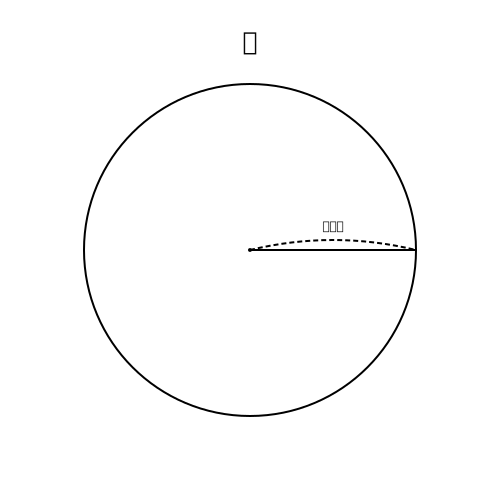

요청한 문장: 원 그리기
추출된 개념: 원
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 230 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="230" font-size="12" text-anchor="middle">반지름</text>
    </svg>
    

생성된 설명:
 ### 원 그리기

#### 정의
원 그리기는 평면 위에 중심점을 정하고, 그 중심점으로부터 일정한 거리(반지름)를 유지하는 모든 점들의 집합을 그리는 것을 말합니다. 이 원은 곡선으로 이루어져 있으며, 가장 기본적인 기하학적 도형 중 하나입니다.

#### 기본 성질
1. **중심점**: 원을 그리는 데 필요한 첫 번째 요소는 중심점입니다. 이 중심점은 원의 모든 점들이 동일한 거리에 위치하게 만드는 기준점입니다.
   
2. **반지름**: 중심점에서 원 위의 어떤 점까지의 거리를 반지름이라고 합니다. 모든 원 위의 점들은 중심점으로부터 같은 거리에 있어야 합니다.

3. **둘레 길이**: 원

<IPython.core.display.Math object>

<IPython.core.display.Math object>

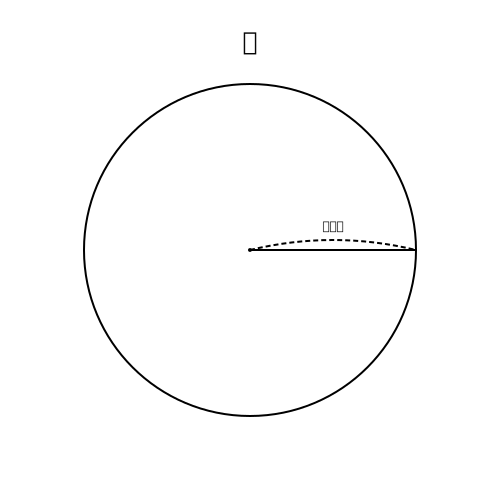

요청한 문장: 원을 이용하여 여러가지 모양 그리기
추출된 개념: 원
추출된 인자: {'radius': None}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 230 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="230" font-size="12" text-anchor="middle">반지름</text>
    </svg>
    

생성된 설명:
 ### 원을 이용한 다양한 모양 그리기

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합으로 정의됩니다. 이 중심점을 기준으로 원의 크기는 반지름의 길이에 따라 달라집니다.

#### 기본 성질:
1. **둘레와 넓이**:
   - **둘레**: 원의 둘레는 반지름에 따라 달라집니다. 공식은 \( C = 2 \times \pi \times r \) 이지만, 여기서는 \( \pi \)를 3.14로 간단히 사용하겠습니다. 따라서, 둘레는 \( C = 2 \times 3.14 \times r \) 입니

<IPython.core.display.Math object>

<IPython.core.display.Math object>

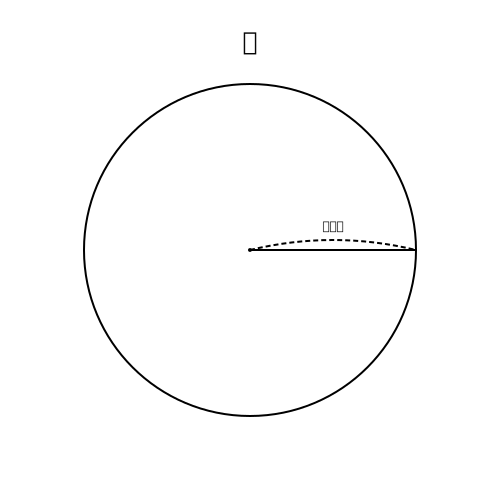

요청한 문장: 각의 크기 비교하기
추출된 개념: 각
추출된 인자: {'size': 60}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="250.00000000000003" y2="116.49364905389035" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 150.0,289.69872981077805 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    <!-- 보조선 -->
    <text x="179.12658773652743" y="301.75" font-size="12" text-anchor="middle">60°</text>
    </svg>
    

생성된 설명:
 ### 각의 크기 비교하기

#### 정의
각의 크기 비교는 두 개 이상의 각도가 얼마나 비슷한지 또는 얼마나 다른지를 알아보는 것입니다. 주로 각도를 측정하거나, 어떤 도형 내에서 각도의 크기를 이해하는 데 사용됩니다.

#### 기본 성질
1. **각도의 크기 순서**: 각도를 비교할 때는 가장 작은 각도부터 가장 큰 각도 순으로 정렬합니다. 예를 들어, 각도 A가 각도 B보다 작다면 A < B라고 표현합니다.
   
2. **도형 내 각도**: 원이나 다각형 내의 각도는 특별한 규칙을 따릅니다. 예를 들어, 정삼각형의 각은 모두 같고 크기는 약 60도

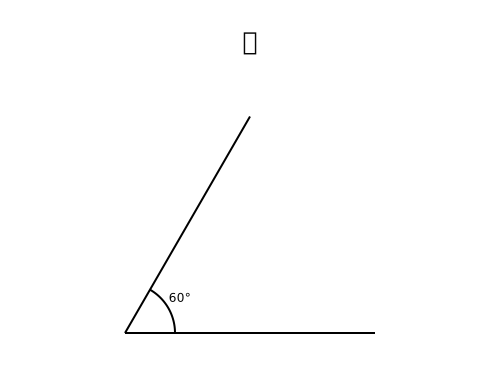

요청한 문장: 각도기를 이용하여 각도 재기
추출된 개념: 각
추출된 인자: {'size': 90}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="250" y1="333" x2="250.00000000000003" y2="83.0" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 250.0,283.0 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
    <!-- 보조선 -->
    <text x="294.19417382415924" y="288.80582617584076" font-size="12" text-anchor="middle">90°</text>
    </svg>
    

생성된 설명:
 ### 각도 재기

#### 정의:
각도 재기는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 이는 우리가 일상생활에서 자주 사용하는 기술로, 건축, 디자인, 게임 등 다양한 분야에서 중요한 역할을 합니다.

#### 기본 성질:
1. **직선과 각도**: 직선은 180도의 각도를 만듭니다. 즉, 두 직선이 서로 만나면 그 교차점에서 생기는 각도는 항상 180도입니다.
   
2. **삼각형의 내각 합**: 삼각형의 세 각의 합은 항상 180도입니다. 이 성질 덕분에 삼각형의 한 각을 알게 되면 다른 두 각을 쉽게 계산할 수 있습니다.

3. **각도

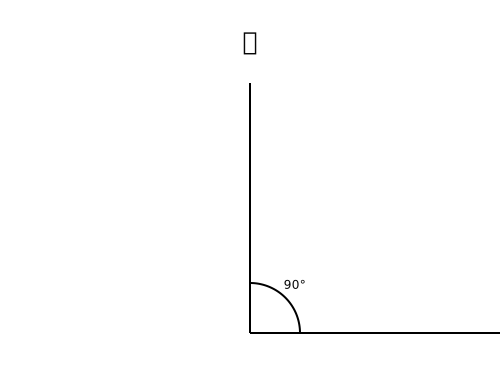

요청한 문장: 각도를 나타내는 단위 알아보기
추출된 개념: 각도 단위
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="12" text-anchor="middle"># 각도 단위을(를) 그리는 코드는 아직 구현되지 않았습니다.</text>
        </svg>
        

생성된 설명:
 ## 각도를 나타내는 단위 알아보기!

**1. 도 (Degree)**

* **정의:** 원을 360등분했을 때 한 바퀴를 이루는 각도를 말해요. 
* **기본 성질:** 
    * 한 바퀴는 360도예요.
    * 반 바퀴는 180도예요.
    * 작은 각도는 1도, 큰 각도는 100도처럼 여러 단위로 나눌 수 있어요.

**2. 분 (Minute)**

* **정의:** 도를 다시 60등분한 각도 단위예요.
* **기본 성질:**
    * 한 도는 60분으로 이루어져 있어요.
    * 예를 들어, 30도는 30분이에요.

**3. 초 (Second)**

* **정의:** 분을 다시 60등분한 가장 작은 각도 단위예요.
* **기본 성질:**
    * 한 분은 60초로 이루어져 있어요.
    * 예를 들어, 1분은 60초예요.

이렇게 각도는 작은 단위부터 큰 단위까지 다양하게 나뉘어 표현되죠!


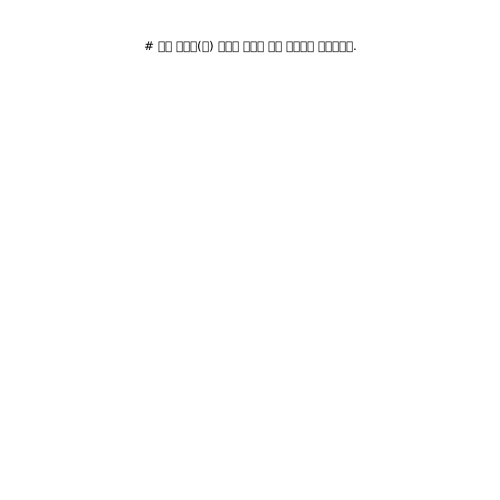

요청한 문장: 각도기와 자를 이용하여 각 그리기
추출된 개념: 각
추출된 인자: {'angle_measure': None, 'tool': '각도기와 자'}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="250.00000000000003" y2="116.49364905389035" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 150.0,289.69872981077805 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    <!-- 보조선 -->
    <text x="179.12658773652743" y="301.75" font-size="12" text-anchor="middle">60°</text>
    </svg>
    

생성된 설명:
 ### 각도기와 자를 이용한 각 그리기 설명

#### 정의:
각도기와 자는 기하학에서 매우 중요한 도구들입니다. 각도기는 두 직선이나 선분 사이의 각도를 정확하게 측정하는 데 사용되며, 자는 직선을 그리거나 길이를 재는 데 사용됩니다.

#### 기본 성질:
1. **각도기 사용**:
   - **목적**: 각도기는 주로 두 선 사이의 각도를 측정하거나 그릴 때 사용됩니다.
   - **작동 방식**: 각도기의 중앙점(보통 '0'이라는 눈금이 있는 부분)을 두 선이 만나는 지점에 맞춥니다.

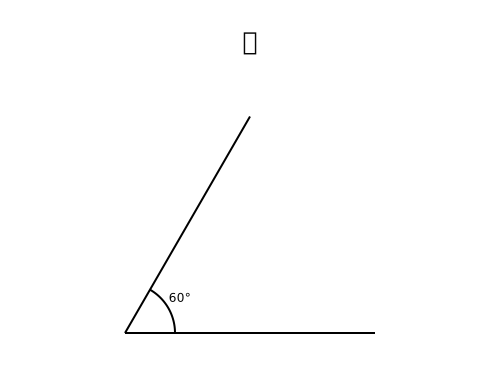

요청한 문장: 예각과 둔각 알아보기
추출된 개념: 각
추출된 인자: {'size': 45}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="301.7766952966369" y2="156.22330470336314" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 160.35533905932738,297.6446609406726 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    <!-- 보조선 -->
    <text x="182.74247078195543" y="309.08228547718187" font-size="12" text-anchor="middle">45°</text>
    </svg>
    

생성된 설명:
 ### 예각과 둔각 알아보기

#### 정의
- **예각**: 삼각형이나 다각형의 각 중에서 크기가 90도보다 작은 각을 말합니다. 쉽게 말해, 눈을 살짝 뜨고 있는 모양처럼 보이는 각입니다.
- **둔각**: 삼각형이나 다각형의 각 중에서 크기가 90도보다 크고 180도보다 작은 각을 의미합니다. 이는 눈을 크게 뜨고 있는 모양처럼 보이는 각입니다.

#### 기본 성질
- **예각**:
  - 예각은 항상 양수입니다 (0도에서 90도 사이).
  - 삼각형에서 예각 두 개와 한 개의 직각(90도)이 있으면 직각

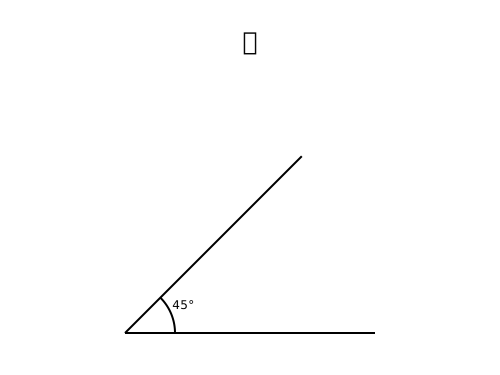

요청한 문장: 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각
추출된 인자: {'estimated_angle_size': None, 'verifying_method': '각도기'}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="250.00000000000003" y2="116.49364905389035" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 150.0,289.69872981077805 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    <!-- 보조선 -->
    <text x="179.12658773652743" y="301.75" font-size="12" text-anchor="middle">60°</text>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

#### 정의
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 각도는 주로 도(°) 단위로 표현되며, 이는 원의 중심각이 한 바퀴(360°)를 완전히 돌았을 때의 각도 크기를 기준으로 합니다.

#### 기본 성질
1. **합과 차**: 여러 각도를 더하거나 뺄 때, 그 결과는 원래 각도와 동일한 방향을 유지합니다. 예를 들어, 45°와 60°를 더하면 105°가 됩니다.
2. **직선의 각도**: 직선

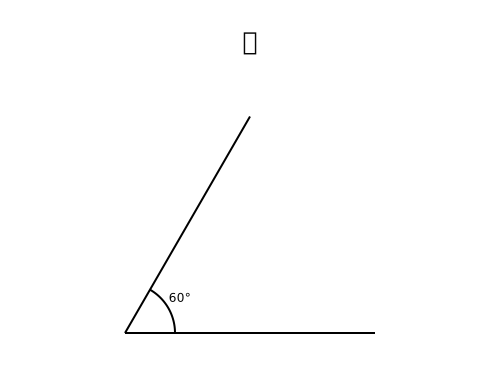

요청한 문장: 각도의 합 또는 차의 활용
추출된 개념: 각의 합
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="12" text-anchor="middle"># 각의 합을(를) 그리는 코드는 아직 구현되지 않았습니다.</text>
        </svg>
        

생성된 설명:
 ### 각도의 합 또는 차의 활용

#### 정의
각도의 합 또는 차의 활용은 여러 각도를 더하거나 빼서 새로운 각도를 구하는 방법을 말합니다. 이는 삼각형의 각도 합이 항상 180도라는 기본 원리를 바탕으로 합니다. 또한, 각도를 더하거나 빼는 것은 실제 생활에서 각도를 계산하거나 문제를 해결할 때 유용하게 사용됩니다.

#### 기본 성질
1. **삼각형의 내각 합**: 삼각형의 세 내각의 합은 항상 180도입니다. 이를 이용하면 삼각형의 한 각도를 구할 때 다른 두 각도를 먼저 알아내는 데 도움이 됩니다.
   
2. **직선 각도**: 직선의 각도는 180도입니다. 따라서 직선을 기준으로 각도를 더하거나 빼면 전체 각도를 쉽게 계산할 수 있습니다.

3. **각도의 덧셈과 뺄셈**: 각도를 더하거나 뺄 때는 각 단위(도, 분, 초)를 고려해야 합니다. 예를 들어, 30도와 45도를 더하면 75도가 됩니다. 각도를 뺄 때는 주의해야 할 점이 있는데, 예를 들어 120도와 60도를 빼면 60도가 되지만, 만약 120도와 60도를 빼면서 시계 방향과 반시계 방향을 고려해야 할 수도 있습니다.

이러한 성질들을 활용하면 다양한 각도 문제를 해결하는 데 도움이 됩니다. 예를 들어, 건물의 각도를 계산하거나, 지도에서 방향을 찾는 데에도 활용될 수 있습니다.


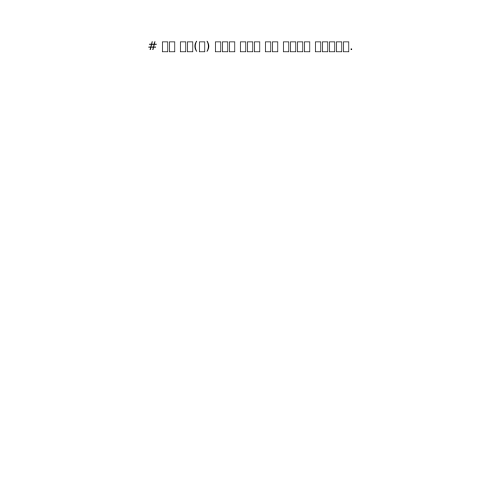

요청한 문장: 두 각도의 차 구하기
추출된 개념: 각도
추출된 인자: {'angle1': None, 'angle2': None}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="250.00000000000003" y2="116.49364905389035" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 150.0,289.69872981077805 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    <!-- 보조선 -->
    <text x="179.12658773652743" y="301.75" font-size="12" text-anchor="middle">60°</text>
    </svg>
    

생성된 설명:
 ### 두 각도의 차 구하기

#### 정의
두 각도의 차는 한 각도에서 다른 각도를 뺀 결과를 말합니다. 즉, 만약 첫 번째 각도를 \( \theta_1 \)이고 두 번째 각도를 \( \theta_2 \)라고 할 때, 두 각도의 차는 \( \theta_2 - \theta_1 \)로 표현됩니다.

#### 기본 성질
1. **순서 무관성**: 각도의 차는 각도의 순서에 상관없이 계산할 수 있습니다. 즉, \( \theta_2 - \theta_1 \)은 \( \theta_1 - \theta_2 \)와 같은 결과를 줍니다

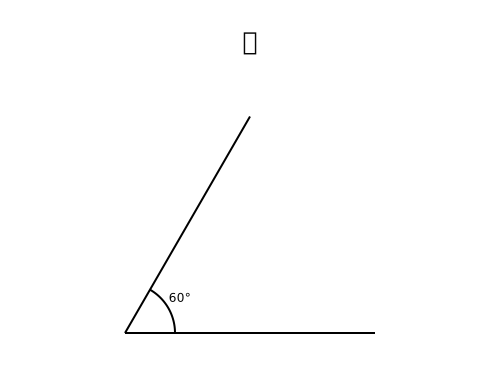

요청한 문장: 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 각
추출된 인자: {'sum_of_angles': 180, 'other_angles': True, 'given_angle': '정보 부족'}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="250.00000000000003" y2="116.49364905389035" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 150.0,289.69872981077805 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    <!-- 보조선 -->
    <text x="179.12658773652743" y="301.75" font-size="12" text-anchor="middle">60°</text>
    </svg>
    

생성된 설명:
 ### 삼각형의 나머지 한 각 구하기

#### 정의:
삼각형의 내각의 합은 항상 **180도**입니다. 이는 삼각형의 기본적인 성질 중 하나입니다. 만약 삼각형의 두 각의 크기를 알고 있다면, 나머지 한 각의 크기를 쉽게 구할 수 있습니다.

#### 기본 성질:
1. **내각의 합**: 삼각형의 세 내각의 합은 항상 **180도**입니다.
2. **각의 관계**: 만약 삼각형의 두 각의 크기를 알고 있다면, 나머지 한 각은 다음과 같이

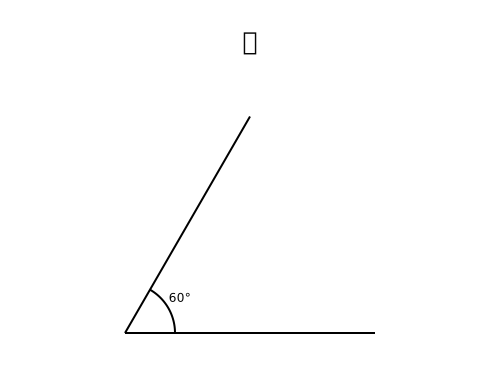

요청한 문장: 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="12" text-anchor="middle"># 삼각형의 내각의 합을(를) 그리는 코드는 아직 구현되지 않았습니다.</text>
        </svg>
        

생성된 설명:
 ### 삼각형의 세 각의 크기의 합

#### 정의:
삼각형은 평면 위에서 세 개의 변과 세 개의 꼭지점으로 이루어진 도형입니다. 삼각형의 각 꼭지점에서 만나는 두 변이 이루는 각도를 각이라고 부릅니다.

#### 기본 성질:
1. **각의 합**: 삼각형의 세 각의 크기의 합은 항상 **180도**입니다. 즉, 어떤 삼각형을 그려도 그 삼각형의 모든 내각을 더하면 항상 180도가 됩니다.
   
   예를 들어, 만약 삼각형의 세 각이 각각 \(A\), \(B\), \(C\)도라면, \(A + B + C = 180^\circ\)가 항상 성립합니다.

이렇게 삼각형의 특성 중 하나로 각의 합이 항상 일정하다는 점을 기억하면 쉽게 문제를 해결할 수 있습니다.


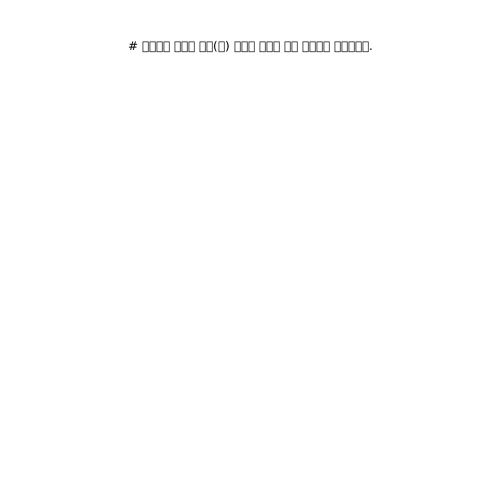

요청한 문장: 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 각도
추출된 인자: {'sides': ['삼각형의 두 등변 각의 합은 항상 180도 이므로', '한 각을 알면 나머지 한 각도 구할 수 있음.'], 'label_angle': '구체적인 각도 값이 아닌 개념 설명이므로 제외'}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="12" text-anchor="middle"># 사각형의 각도을(를) 그리는 코드는 아직 구현되지 않았습니다.</text>
        </svg>
        

생성된 설명:
 ### 사각형의 나머지 한 각의 크기 구하기

#### 정의:
사각형은 네 개의 변과 네 개의 내각을 가진 평면 도형입니다. 모든 사각형의 내각의 합은 항상 **360도**입니다.

#### 기본 성질:
1. **대칭성**: 사각형은 대칭성이 있어, 특정 조건 하에 각이 서로 같아질 수 있습니다. 예를 들어, 직사각형이나 정사각형에서는 모든 내각이 **각각 90도**입니다.
2. **내각의 합**: 사각형의 네 내각의 합은 항상 **360도**입니다. 만약 세 내각의 크기를 알고 있다면, 나머지 한 내각의 크기를 쉽게 구할 수 있습니다.

#### 구하는 방법 예시:
- **예시**: 만약 사각형의 세 내각의 크기가 각각 **70도**, **80도**, 그리고 **100도**라면, 나머지 한 내각의 크기를 구할 수 있습니다.
  - 세 내각의 합: \(70^\circ + 80^\circ + 100^\circ = 250^\circ\)
  - 사각형의 내각 합이 \(360^\circ\)이므로, 나머지 한 내각의 크기는:
    \[
    360^\circ - 250^\circ = 110^\circ
    \]
  - 따라서, 나머지 한 내각의 크기는 **110도**입니다.

이렇게

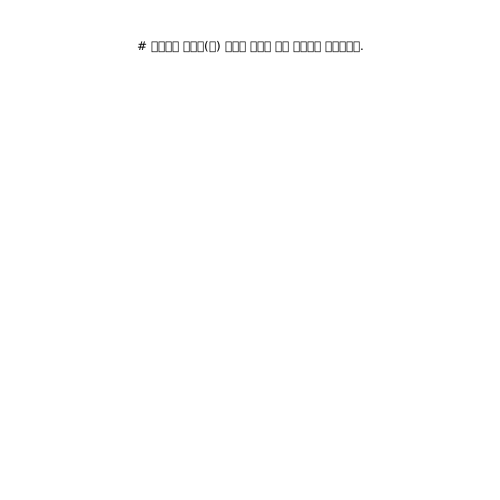

요청한 문장: 사각형의 네 각의 크기의 합 구하기
추출된 개념: 각의 합
추출된 인자: {'sum': 360}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="12" text-anchor="middle"># 각의 합을(를) 그리는 코드는 아직 구현되지 않았습니다.</text>
        </svg>
        

생성된 설명:
 ### 사각형의 네 각의 크기의 합

#### 정의:
사각형은 네 개의 변과 네 개의 꼭지점을 가진 평면 도형입니다. 각 꼭지점에서 만나는 두 변이 이루는 각도를 각이라고 부릅니다.

#### 기본 성질:
1. **각의 합**: 사각형의 네 각의 크기의 합은 항상 **360도**입니다. 이는 사각형을 여러 개의 삼각형으로 나눌 수 있으며, 삼각형의 세 각의 합이 항상 180도라는 사실에서 유래됩니다. 따라서 네 개의 삼각형을 합치면 총 합이 360도가 됩니다.
   
   예를 들어, 만약 사각형의 네 각이 각각 \(A\), \(B\), \(C\), \(D\)라고 하면:
   \[
   A + B + C + D = 360^\circ
   \]

이렇게 사각형의 네 각의 합은 항상 일정하게 유지됩니다.


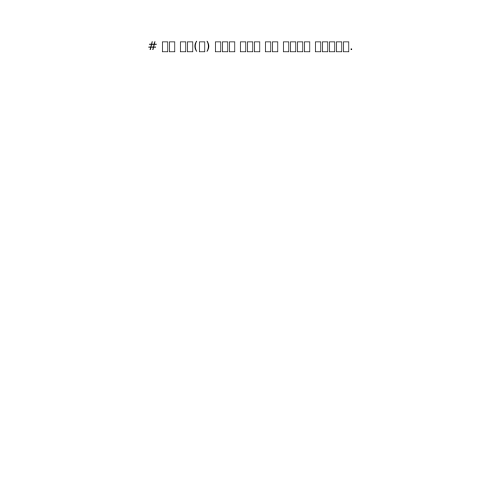

요청한 문장: 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류
추출된 인자: {'side_length': '예: 3, 4, 5'}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="12" text-anchor="middle"># 삼각형 분류을(를) 그리는 코드는 아직 구현되지 않았습니다.</text>
        </svg>
        

생성된 설명:
 ### 삼각형의 변의 길이에 따른 분류

#### 정의:
삼각형은 세 개의 변과 세 개의 꼭지점으로 이루어진 평면 도형입니다. 삼각형은 그 변의 길이에 따라 여러 가지로 분류할 수 있습니다.

#### 기본 성질:
1. **예각삼각형**:
   - **정의**: 모든 내각의 크기가 90도보다 작은 삼각형입니다.
   - **특징**: 가장 긴 변(빗변)의 길이가 다른 두 변의 길이의 합보다 작습니다.

2. **직각삼각형**:
   - **정의**: 한 내각이 정확히 90도인 삼각형입니다.
   - **특징**: 빗변(가장 긴 변)의 길이는 다른 두 변(직각을 이루는 변들)의 길이의 제곱의 합의 제곱근과 같습니다. 하지만 여기서는 변의 길이에 대한 직접적인 공식보다는 그 특징에 초점을 맞춥니다.

3. **둔각삼각형**:
   - **정의**: 한 내각의 크기가 90도보다 큰 삼각형입니다.
   - **특징**: 가장 긴 변(빗변)의 길이가 다른 두 변의 길이의 합보다 큽니다.

이렇게 삼각형은 변의 길이에 따라 예각삼각형, 직각삼각형, 둔각삼각형으로 구분됩니다. 각 종류의 삼각형은 그 특징적인 내각의 크기와 변의 길이 관계로 구별됩니다.


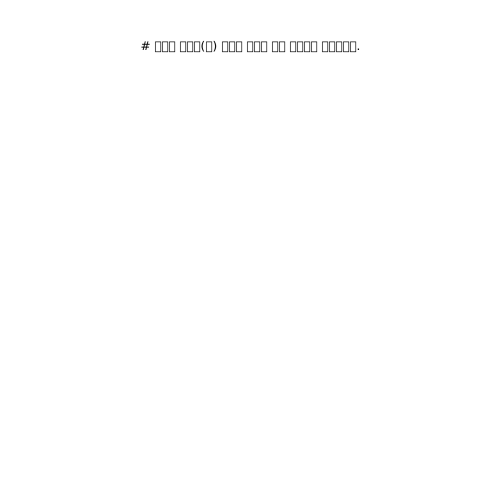

요청한 문장: 이등변삼각형 알아보기
추출된 개념: 이등변삼각형
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <path d="M 250, 125 Q 307.0, 220.0 314.7047612756302, 366.4814565722671" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
        <text x="307.0" y="220.0" font-size="12" text-anchor="middle">등변</text>
        <line x1="290.0797872481276" y1="243.6701759253134" x2="274.62497402750256" y2="247.81128064695372" stroke="black" stroke-width="2" />
        <line x1="225.37502597249747" y1="247.81128064695372" x2="209.92021275187236" y2="243.6701759253134" stroke="black" stroke-width="2" />
        </svg>
        

생성된 설명:
 ### 이등변삼각형 알아보기

#### 정의
이등변삼각형은 삼각형의 세 변 중에서 **

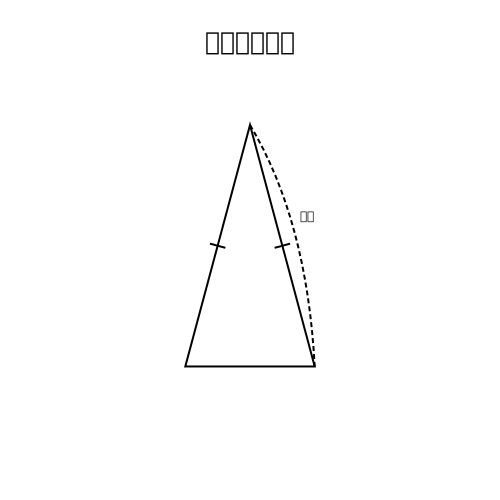

요청한 문장: 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형
추출된 인자: {'base_length': 5}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <path d="M 250, 125 Q 307.0, 220.0 314.7047612756302, 366.4814565722671" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
        <text x="307.0" y="220.0" font-size="12" text-anchor="middle">등변</text>
        <line x1="290.0797872481276" y1="243.6701759253134" x2="274.62497402750256" y2="247.81128064695372" stroke="black" stroke-width="2" />
        <line x1="225.37502597249747" y1="247.81128064695372" x2="209.92021275187236" y2="243.6701759253134" stroke="black" stroke-width="2" />
        </svg>
        

생성된 설명:
 ### 이등변삼각형의 성질

#### 정의
이등변삼

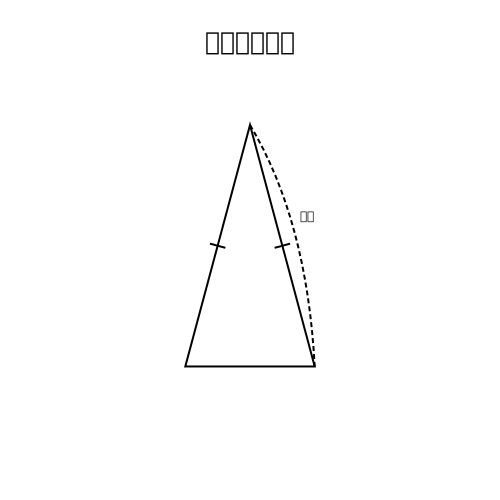

TypeError: '<=' not supported between instances of 'dict' and 'int'

In [23]:
# %%timeit -n 5 -r 6

# 그래프 호출
for i, user_input in enumerate(input_samples):
    result = app.invoke({"user_request": user_input})

    # 결과 출력
    print("요청한 문장:", result["user_request"])
    print("추출된 개념:", result["math_concept"])
    print("추출된 인자:", result["parameters"])
    print("\n생성된 코드:\n", result["generated_code"])
    print("\n생성된 설명:\n", result["comments"])
    if "formulas" in result.keys():
        print("\n생성된 공식 raw:\n", result["formulas"])
        show_formulas(result["formulas"]["perimeter"])
        show_formulas(result["formulas"]["area"])
    show_svg(result["generated_code"])
    print("=" * 100)